# Join NEXIS and Council data for Launceston


In [1]:
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt

### NEXIS data

In [2]:
nexis_filepath = '/Users/Fangyuan/FrontierSI/Projects - Documents/Projects - Data Analytics/127 Residential Dwelling Floor Height/4 Executing/GA_data_documentation/nexis_building_data/launceston_nexis.gpkg'

df_nexis = gpd.read_file(nexis_filepath)
df_nexis.head()

,LID,LONGITUDE,LATITUDE,STE_CODE,STATE_ABBREV,STATE_NAME,SA1_CODE,SA2_CODE,SA2_Name,SUBURB,...,GENERIC_EXT_WALL,flood_vulnerability_function_id,floor_height_(m),floor_height_(cm),LOCAL_NO_OF_STOREYS,NEXIS_NO_OF_STOREYS,REPLACEMENT_VALUE,CONTENTS_VALUE,BATCH,geometry
0,GNAF_GATAS702766152,147.189530,-41.451936,6,TAS,Tasmania,60201104302,602011043,Norwood (Tas.),Norwood Tas,...,lightweight_cladding,FCM1,0.280,28.0,0,1,418335,77500,20240506-2121.b13ac.15-9,POINT (147.18953 -41.45194)
1,GNAF_GATAS702292697,147.148213,-41.452545,6,TAS,Tasmania,60201104709,602011047,South Launceston,South Launceston,...,lightweight_cladding,FCM1,1.895,189.5,0,1,258754,77500,20240506-2121.b13ac.15-9,POINT (147.14821 -41.45254)
2,GNAF_GATAS702300264,147.148311,-41.452508,6,TAS,Tasmania,60201104709,602011047,South Launceston,South Launceston,...,lightweight_cladding,FCM1,0.848,84.8,0,1,242069,77500,20240506-2121.b13ac.15-9,POINT (147.14831 -41.45251)
3,GNAF_GATAS717491059,147.157597,-41.452398,6,TAS,Tasmania,60201104206,602011042,Newstead,Newstead Tas,...,brick_veneer,FCM7,0.523,52.3,0,1,245844,77500,20240506-2121.b13ac.15-9,POINT (147.15760 -41.45240)
4,GNAF_GATAS702223949,147.135884,-41.452491,6,TAS,Tasmania,60201105108,602011051,West Launceston,West Launceston,...,lightweight_cladding,FCM1,0.987,98.7,0,1,322853,77500,20240506-2121.b13ac.15-9,POINT (147.13588 -41.45249)


### City council data

In [3]:
# file
council_filepath = '/Users/Fangyuan/FrontierSI/Projects - Documents/Projects - Data Analytics/127 Residential Dwelling Floor Height/4 Executing/GA_data_documentation/Launceston Exposure Data/LC_Final.zip'

In [4]:
df = gpd.read_file(council_filepath)
df.head()

,EASTING,NORTHING,UFI,ZONE,DEM,LID,ADDRESS,SUBURB,POSTCODE,FEATURE_NA,...,Min_OBJECT,LCC_FLOOR,check1,POINT_X_1,POINT_Y_1,ROWS,SA11,GVULN,GVULV,geometry
0,510962.988188,5.412541e+06,1002,15.0 Urban Mixed Use,2.697813,GNAF_GATAS702308914,13 PARK STREET,LAUNCESTON,7250,None,...,1061.0,3.12,0.0,147.131228,-41.438625,1.0,6.020110e+10,4.0,10.0,POINT (510962.988 5412541.233)
1,511021.688427,5.412248e+06,33,11.0 Inner Residential,4.208417,GNAF_GATAS702204375,293 BRISBANE STREET,LAUNCESTON,7250,None,...,0.0,3.33,0.0,147.131936,-41.441268,1.0,6.020110e+10,4.0,10.0,POINT (511021.688 5412247.723)
2,511082.136711,5.412226e+06,31,11.0 Inner Residential,4.540370,GNAF_GATAS702478623,4 MIDDLE STREET,LAUNCESTON,7250,None,...,0.0,3.70,0.0,147.132660,-41.441464,1.0,6.020110e+10,4.0,10.0,POINT (511082.137 5412225.871)
3,511068.760790,5.412219e+06,28,11.0 Inner Residential,5.212643,GNAF_GATAS702296648,6 MIDDLE STREET,LAUNCESTON,7250,None,...,0.0,3.37,0.0,147.132500,-41.441522,1.0,6.020110e+10,4.0,10.0,POINT (511068.761 5412219.452)
4,511048.726805,5.412229e+06,26,11.0 Inner Residential,5.162260,GNAF_GATAS702290011,8 MIDDLE STREET,LAUNCESTON,7250,None,...,0.0,3.37,0.0,147.132260,-41.441433,1.0,6.020110e+10,4.0,10.0,POINT (511048.727 5412229.364)


In [5]:
df_r = df[df.USE=='Residential']
df_r['Floor_Height'] = df_r.LCC_FLOOR - df_r.DEM

/Users/Fangyuan/miniconda/envs/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Join

In [6]:
df_nexis = df_nexis.to_crs(df_r.crs)

In [7]:
nearby_points = gpd.sjoin_nearest(df_nexis, df_r, max_distance=5, how='inner', distance_col="distance")
print("# of match", len(nearby_points))

# Calculate correlation
correlation = nearby_points['floor_height_(m)'].corr(nearby_points['Floor_Height'])
print(f"Correlation between {'floor_height_(m)'} and {'Floor_Height'}: {correlation}")

one_to_one_matches = nearby_points.groupby('index_right').filter(lambda x: len(x) == 1)
print("# of one to one match", len(one_to_one_matches))

# of mismatch
print("# of mismatched height", (np.abs(nearby_points['floor_height_(m)']-nearby_points.Floor_Height)>1e-3).sum())

# of match 628
Correlation between floor_height_(m) and Floor_Height: 0.019613025698802748
# of one to one match 628
# of mismatched height 626


<Axes: ylabel='Frequency'>

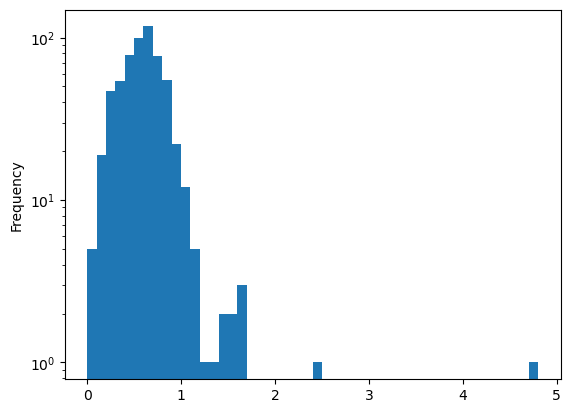

In [8]:
nearby_points.Floor_Height.plot.hist(bins=np.arange(0,df_r.Floor_Height.max()+0.1,0.1), logy=True)

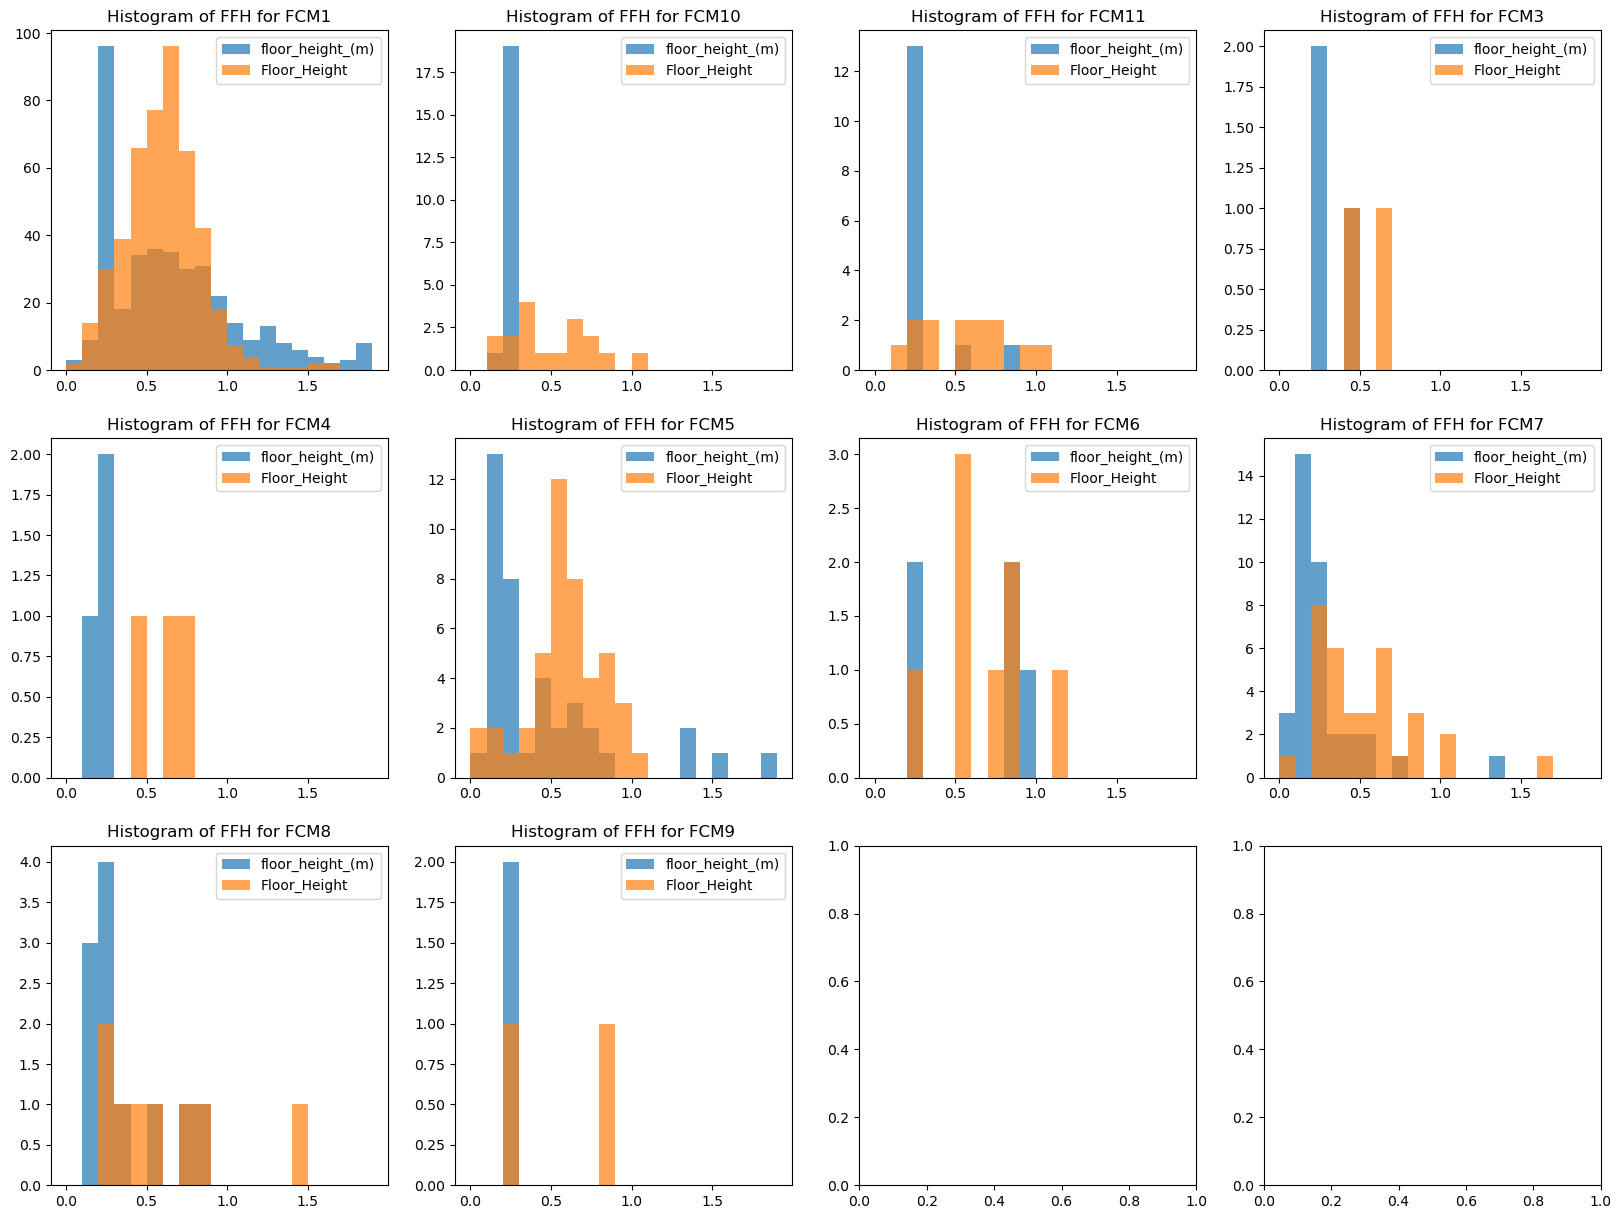

In [9]:
unique_build_types = np.sort(nearby_points['flood_vulnerability_function_id'].unique())
num_build_types = len(unique_build_types)
fig, axes = plt.subplots(nrows=(num_build_types + 3) // 4, ncols=4, figsize=(20, 5 * ((num_build_types + 3) // 4)))
axes = axes.flatten()

ffh_col_1 = 'floor_height_(m)'
ffh_col_2 = 'Floor_Height'
for ax, build_type in zip(axes, unique_build_types):
    group = nearby_points[nearby_points['flood_vulnerability_function_id'] == build_type]
        
    ax.hist(group[ffh_col_1][group[ffh_col_1]>=0], bins=np.arange(0,2,0.1), alpha=0.7, label=ffh_col_1, density=False)
    ax.hist(group[ffh_col_2][group[ffh_col_2]>=0], bins=np.arange(0,2,0.1), alpha=0.7, label=ffh_col_2, density=False)
    
    ax.set_title(f'Histogram of FFH for {build_type}')
    ax.legend()

### Building footprint

In [10]:

overture_filepath = '/Users/Fangyuan/FrontierSI/Projects - Documents/Projects - Data Analytics/127 Residential Dwelling Floor Height/4 Executing/Data Exploration/overture/launceston_building.gpkg'

In [11]:
footprint = gpd.read_file(overture_filepath)

In [12]:
footprint.head()

,id,min_height_ahd,max_height_ahd,geometry
0,5ba66050-bb4c-44ae-a94d-ba2225385e8b,211.220,211.925,"POLYGON ((147.08401 -41.45250, 147.08407 -41.4..."
1,4175cad2-999d-44e3-a6b7-deb2bc25009e,211.700,211.740,"POLYGON ((147.08416 -41.45258, 147.08424 -41.4..."
2,e212aad3-a557-4123-bbef-b817dae4aa9b,211.350,211.790,"POLYGON ((147.08427 -41.45258, 147.08436 -41.4..."
3,a3dc6530-7b7c-41e5-bca9-c30c879598da,207.660,210.443,"POLYGON ((147.08377 -41.45214, 147.08362 -41.4..."
4,4bb13f43-5d95-4adc-a238-a7cea5b4adad,141.472,142.290,"POLYGON ((147.08746 -41.44759, 147.08746 -41.4..."


In [13]:
footprint.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
nearby_points.rename(columns={'index_right':'index_nexis'}, inplace=True)

In [15]:
nearby_points.columns

Index(['LID_left', 'LONGITUDE', 'LATITUDE', 'STE_CODE', 'STATE_ABBREV',
       'STATE_NAME', 'SA1_CODE_left', 'SA2_CODE_left', 'SA2_Name',
       'SUBURB_left', 'POSTCODE_left', 'LGA_CODE', 'LGA_NAME', 'UCL_CODE',
       'UCL_NAME', 'NEXIS_USE_II', 'NEXIS_CONSTRUCTION_TYPE',
       'LOCAL_YEAR_BUILT', 'NEXIS_YEAR_BUILT', 'NEXIS_WALL_TYPE',
       'GENERIC_EXT_WALL', 'flood_vulnerability_function_id',
       'floor_height_(m)', 'floor_height_(cm)', 'LOCAL_NO_OF_STOREYS',
       'NEXIS_NO_OF_STOREYS', 'REPLACEMENT_VALUE', 'CONTENTS_VALUE', 'BATCH',
       'geometry', 'index_nexis', 'EASTING', 'NORTHING', 'UFI', 'ZONE', 'DEM',
       'LID_right', 'ADDRESS', 'SUBURB_right', 'POSTCODE_right', 'FEATURE_NA',
       'NEXIS_CAD_', 'NEXIS_CAD1', 'SA1_CODE_right', 'SA2_CODE_right',
       'LGA_CODE_2', 'MB_CODE_20', 'GCC_CODE_2', 'SETTLEMENT', 'LOCAL_USE',
       'NEXIS_USE_', 'NEXIS_USE1', 'ABS_BusReg', 'Survey_Res', 'Survey_COM',
       'Survey_Grd', 'Survey_G_1', 'Survey_Bas', 'Survey_Gar', 'S

In [16]:
import os

if os.path.exists('launceston_FFH_footprint_geometry.geojson'):
    df_footprint = gpd.read_file('launceston_FFH_footprint_geometry.geojson')
else:
    footprint = footprint.to_crs(nearby_points.crs)

    # Perform spatial join and retain one-to-one matches

    # Step 1: Perform the spatial join
    df_intersections = gpd.sjoin(nearby_points, footprint, how='inner', predicate='intersects')

    # Step 2: Identify one-to-one matches by counting intersections for each index in both dataframes
    one_to_one_matches = df_intersections.groupby('index_right').filter(lambda x: len(x) == 1)
    
    # Save
    one_to_one_matches.to_file('launceston_FFH_with_footprint.geojson')
    one_to_one_matches['geometry'] = footprint.loc[one_to_one_matches.index_right].geometry.values
    one_to_one_matches.to_file('launceston_FFH_footprint_geometry.geojson')

    len(one_to_one_matches)

In [17]:
one_to_one_matches.head()

,LID_left,LONGITUDE,LATITUDE,STE_CODE,STATE_ABBREV,STATE_NAME,SA1_CODE_left,SA2_CODE_left,SA2_Name,SUBURB_left,...,ROWS,SA11,GVULN,GVULV,Floor_Height,distance,index_right,id,min_height_ahd,max_height_ahd
3685,GNAF_GATAS702473195,147.134778,-41.441476,6,TAS,Tasmania,60201103810,602011038,Launceston,Launceston,...,1.0,6.020110e+10,4.0,10.0,-3.581172,0.025285,7991,75c96aa4-c596-4dcb-a3db-9f902e3a1a70,3.468,3.750
3690,GNAF_GATAS702288902,147.132968,-41.441479,6,TAS,Tasmania,60201103810,602011038,Launceston,Launceston,...,1.0,6.020110e+10,4.0,10.0,-0.354853,0.028699,7837,05b2581d-88f0-4425-83aa-db4b93d4630e,3.870,4.610
3693,GNAF_GATAS702290011,147.132260,-41.441433,6,TAS,Tasmania,60201103810,602011038,Launceston,Launceston,...,1.0,6.020110e+10,4.0,10.0,-1.792260,0.065698,7827,2b6477a2-3ec0-4138-9360-2fd924660664,4.530,5.990
3701,GNAF_GATAS702296648,147.132500,-41.441522,6,TAS,Tasmania,60201103810,602011038,Launceston,Launceston,...,1.0,6.020110e+10,4.0,10.0,-1.842643,0.020538,7831,e2fdd73f-987a-4a4b-9e91-958c6a9217dc,3.840,5.649
3710,GNAF_GATAS702478623,147.132660,-41.441464,6,TAS,Tasmania,60201103810,602011038,Launceston,Launceston,...,1.0,6.020110e+10,4.0,10.0,-0.840370,0.031534,7832,d30c5eec-136a-4454-8d76-786f1ee6e529,3.985,4.960


In [18]:
len(one_to_one_matches)

568